## Imports

In [1]:

import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from graphs import plot_correlation_matrix

import torch
from torchvision import datasets, transforms

#quanutm lib
import pennylane as qml
from pennylane import numpy as np

from pennylane.optimize import AdamOptimizer

import torch
from torchvision import datasets, transforms

C:\Users\tomut\anaconda3\envs\qhack2022\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\tomut\anaconda3\envs\qhack2022\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
import sys
sys.path.append("..") # Adds higher directory to python modules path

from qencode.initialize import setAB_amplitude, setAux, setEnt
from qencode.encoders import e3_enhance
from qencode.training_circuits import swap_t
from qencode.qubits_arrangement import QubitsArrangement

from qencode.utils.mnist import get_dataset

## Data

In [3]:
df=pd.read_csv("cancer.csv", nrows=500)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
diagnosis=[]
for d in df.diagnosis:
    if d=="M":
        diagnosis.append(1.0)
    else:
        diagnosis.append(0.0)
df["diagnosis"]=diagnosis

In [5]:
print('Benign: ', df['diagnosis'].value_counts()[0])
print('Malign: ', df['diagnosis'].value_counts()[1])

Benign:  305
Malign:  195


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       500 non-null    int64  
 1   diagnosis                500 non-null    float64
 2   radius_mean              500 non-null    float64
 3   texture_mean             500 non-null    float64
 4   perimeter_mean           500 non-null    float64
 5   area_mean                500 non-null    float64
 6   smoothness_mean          500 non-null    float64
 7   compactness_mean         500 non-null    float64
 8   concavity_mean           500 non-null    float64
 9   concave points_mean      500 non-null    float64
 10  symmetry_mean            500 non-null    float64
 11  fractal_dimension_mean   500 non-null    float64
 12  radius_se                500 non-null    float64
 13  texture_se               500 non-null    float64
 14  perimeter_se             5

In [7]:
df.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,0.0
mean,3.263049e+07,0.390000,14.224206,19.086320,92.606620,662.844800,0.095978,0.103948,0.089941,0.049446,...,25.508500,108.258320,896.003200,0.131972,0.256324,0.276420,0.115980,0.292212,0.083778,NaN
std,1.326933e+08,0.488238,3.476809,4.164842,23.983476,349.357241,0.013666,0.053096,0.080259,0.038875,...,6.063133,33.312706,571.074422,0.022739,0.159147,0.209012,0.065896,0.063366,0.018108,NaN
min,8.670000e+03,0.000000,6.981000,9.710000,43.790000,143.500000,0.062510,0.019380,0.000000,0.000000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.667040e+05,0.000000,11.807500,16.070000,75.995000,430.550000,0.085992,0.063622,0.028885,0.020245,...,21.017500,84.567500,522.600000,0.116200,0.145925,0.114475,0.063302,0.251700,0.071270,NaN
50%,9.014320e+05,0.000000,13.435000,18.680000,86.735000,556.150000,0.095825,0.091280,0.064315,0.033870,...,25.240000,97.980000,691.750000,0.131250,0.214850,0.231400,0.100650,0.283100,0.079900,NaN
75%,8.910808e+06,1.000000,16.115000,21.562500,106.225000,800.775000,0.105100,0.130500,0.132150,0.074928,...,29.350000,127.150000,1150.750000,0.146000,0.343525,0.389450,0.166850,0.320050,0.092065,NaN
max,9.113205e+08,1.000000,28.110000,39.280000,188.500000,2501.000000,0.144700,0.345400,0.426800,0.201200,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


In [8]:
#Data seams pretty clean  without any nan value 

In [9]:
## engineering two new features to have 32 feutures that can be encoded om 5 qubits.
over_average = []
under_average = []

mean = {}
std = {}
for col in df:
     if col not in ["id","diagnosis" ]:
        mean[col]=df[col].mean()
        std[col]=df[col].std()

for index,row in df.iterrows():
    o_average=0
    u_average=0
    for col in df:
        if col not in ["id","diagnosis" ]:
            if  row[col]> mean[col]+2* std[col]:
                o_average = o_average + 1
            if  row[col]< mean[col]+2* std[col]:
                u_average= u_average + 1
                
    over_average.append(o_average)
    under_average.append(u_average)

df["over_average"] = over_average
df["under_average"] = under_average

df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,over_average,under_average
0,842302,1.0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN,13,17
1,842517,1.0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN,0,30
2,84300903,1.0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN,1,29
3,84348301,1.0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN,12,18
4,84358402,1.0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN,0,30


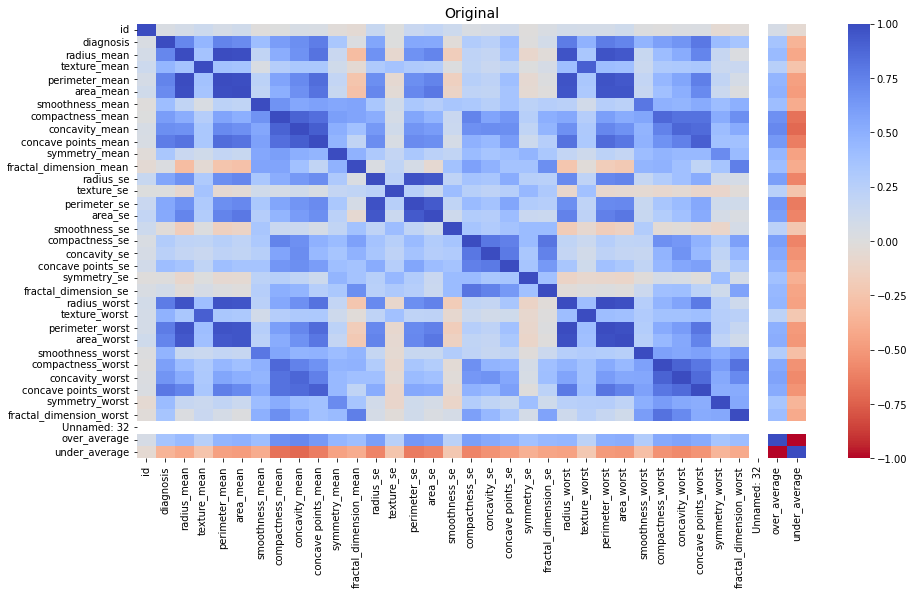

In [10]:
plot_correlation_matrix(df, "Original")

In [11]:
df = df.sample(frac=1)
fraud_df = df.loc[df['diagnosis'] == 0][:195]
non_fraud_df = df.loc[df['diagnosis'] == 1]
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
sub_sample_df = normal_distributed_df.sample(frac=1, random_state=42)

sub_sample_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,over_average,under_average
475,911408,0.0,12.83,15.73,82.89,506.9,0.09040,0.08269,0.058350,0.030780,...,605.8,0.1326,0.26100,0.347600,0.09783,0.3006,0.07802,NaN,0,30
294,891716,0.0,12.72,13.78,81.78,492.1,0.09667,0.08393,0.012880,0.019240,...,553.7,0.1298,0.14720,0.052330,0.06343,0.2369,0.06922,NaN,0,30
333,897137,0.0,11.25,14.78,71.38,390.0,0.08306,0.04458,0.000974,0.002941,...,492.7,0.1166,0.09794,0.005518,0.01667,0.2815,0.07418,NaN,0,30
62,858986,1.0,14.25,22.15,96.42,645.7,0.10490,0.20080,0.213500,0.086530,...,959.5,0.1640,0.62470,0.692200,0.17850,0.2844,0.11320,NaN,2,28
70,859575,1.0,18.94,21.31,123.60,1130.0,0.09009,0.10290,0.108000,0.079510,...,1866.0,0.1193,0.23360,0.268700,0.17890,0.2551,0.06589,NaN,0,30


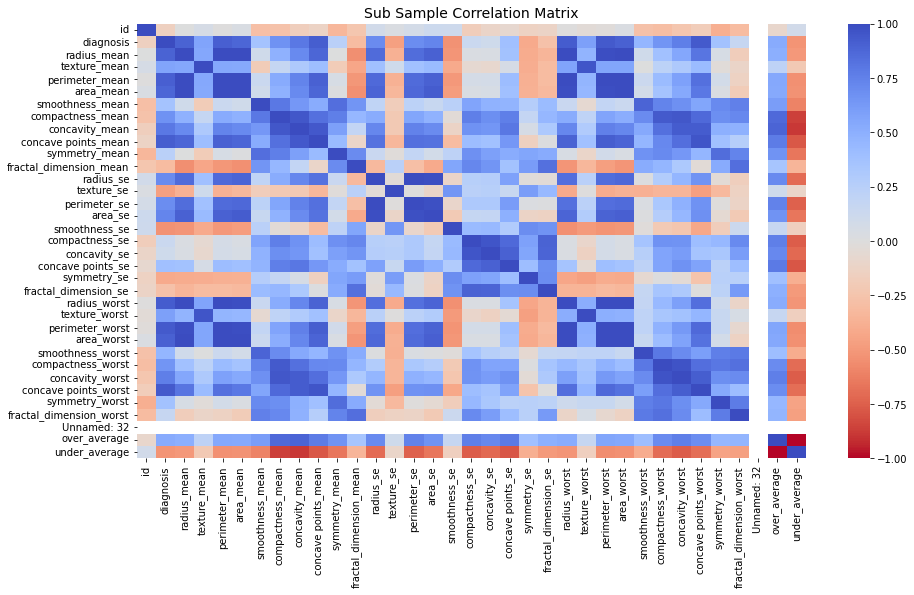

In [12]:
sub_sample_corr = sub_sample_df.corr()
plot_correlation_matrix(sub_sample_corr, "Sub Sample Correlation Matrix")

In [13]:
for col in df:
    if col not in ["id","diagnosis" ]:
        df[col]=df[col]/df[col].max()
df.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,over_average,under_average
count,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,0.0,500.000000,500.000000
mean,3.263049e+07,0.390000,0.506019,0.485904,0.491282,0.265032,0.663292,0.300949,0.210733,0.245754,...,0.210626,0.592867,0.242273,0.220783,0.398557,0.440211,0.403749,NaN,0.062500,0.958333
std,1.326933e+08,0.488238,0.123686,0.106030,0.127233,0.139687,0.094446,0.153722,0.188047,0.193216,...,0.134244,0.102153,0.150423,0.166943,0.226448,0.095459,0.087266,NaN,0.140564,0.093709
min,8.670000e+03,0.000000,0.248346,0.247200,0.232308,0.057377,0.431997,0.056109,0.000000,0.000000,...,0.043535,0.319721,0.025794,0.000000,0.000000,0.235764,0.265253,NaN,0.000000,0.333333
25%,8.667040e+05,0.000000,0.420046,0.409114,0.403156,0.172151,0.594281,0.184199,0.067678,0.100621,...,0.122849,0.522013,0.137925,0.091434,0.217534,0.379180,0.343470,NaN,0.000000,0.966667
50%,9.014320e+05,0.000000,0.477944,0.475560,0.460133,0.222371,0.662232,0.264273,0.150691,0.168340,...,0.162612,0.589623,0.203072,0.184824,0.345876,0.426484,0.385060,NaN,0.000000,1.000000
75%,8.910808e+06,1.000000,0.573284,0.548943,0.563528,0.320182,0.726330,0.377823,0.309630,0.372403,...,0.270510,0.655885,0.324693,0.311062,0.573368,0.482148,0.443687,NaN,0.050000,1.000000
max,9.113205e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000


In [14]:
def find_strongest_correlations(dataframe, qubits):
        
    class_correlations = dataframe.loc['diagnosis', :]
    class_correlations = class_correlations.drop(index = 'diagnosis')
    
    feature_list = list(class_correlations.index)
    correlation_list = [class_correlations[x] for x in feature_list]
    
    features = []
    correlations = []
    
    for i in range(int(qubits/2)):
        
        
        correlations.append(max(correlation_list))
        features.append(feature_list[correlation_list.index(max(correlation_list))])
        
        del feature_list[correlation_list.index(max(correlation_list))]
        del correlation_list[correlation_list.index(max(correlation_list))]                        
                                      
        correlations.append(min(correlation_list))
        features.append(feature_list[correlation_list.index(min(correlation_list))])
        
        del feature_list[correlation_list.index(min(correlation_list))]
        del correlation_list[correlation_list.index(min(correlation_list))] 
    
    return features, correlations
    
    
print(find_strongest_correlations(sub_sample_corr, 32))

(['concave points_worst', 'under_average', 'perimeter_worst', 'symmetry_se', 'radius_worst', 'texture_se', 'concave points_mean', 'smoothness_se', 'perimeter_mean', 'fractal_dimension_mean', 'radius_mean', 'id', 'area_worst', 'fractal_dimension_se', 'area_mean', 'concavity_se', 'concavity_mean', 'compactness_se', 'concavity_worst', 'over_average', 'compactness_mean', 'symmetry_mean', 'compactness_worst', 'fractal_dimension_worst', 'radius_se', 'symmetry_worst', 'perimeter_se', 'smoothness_mean', 'area_se', 'concave points_se', 'smoothness_worst', 'texture_mean'], [0.7910607891913639, -0.32390677244738303, 0.767196247891603, -0.030609992407972526, 0.7605594485474327, -0.022002563329459747, 0.7571047495964567, -0.014452062087306521, 0.726884179332992, 0.0025392992338244464, 0.7153817184275444, 0.01572002120138513, 0.701303424700254, 0.05433716418673085, 0.6794947110838122, 0.22013976762455573, 0.662639615994241, 0.2830211737007386, 0.6526175291304988, 0.32390677244738314, 0.5983100260367

In [15]:
feature_list, correlations = find_strongest_correlations(sub_sample_corr, 32)

In [16]:
malign=df[df["diagnosis"]==0][feature_list]
malign.head()

,concave points_worst,under_average,perimeter_worst,symmetry_se,radius_worst,texture_se,concave points_mean,smoothness_se,perimeter_mean,fractal_dimension_mean,...,compactness_worst,fractal_dimension_worst,radius_se,symmetry_worst,perimeter_se,smoothness_mean,area_se,concave points_se,smoothness_worst,texture_mean
170,0.322715,1.000000,0.346218,0.243699,0.374584,0.136254,0.183897,0.258432,0.418302,0.611145,...,0.119660,0.326313,0.082144,0.425881,0.075978,0.710435,0.032147,0.235082,0.622192,0.315428
296,0.109759,1.000000,0.288296,0.372514,0.315483,0.210235,0.068042,0.111725,0.366790,0.618945,...,0.070945,0.320145,0.061016,0.322838,0.057643,0.588666,0.020454,0.177931,0.418329,0.314409
50,0.127663,1.000000,0.330334,0.304750,0.360155,0.247697,0.055417,0.188146,0.396393,0.604269,...,0.081427,0.316289,0.141385,0.366526,0.119882,0.596890,0.052508,0.141030,0.487421,0.549898
114,0.360825,0.966667,0.256688,0.216339,0.267148,0.120041,0.095626,0.265371,0.296233,0.783354,...,0.223440,0.490120,0.057953,0.440795,0.061601,0.794748,0.016536,0.197007,0.774483,0.403004
299,0.107388,1.000000,0.279061,0.438759,0.303274,0.233982,0.093191,0.326695,0.354642,0.672824,...,0.081418,0.326602,0.099826,0.335493,0.104140,0.701451,0.037920,0.236787,0.513477,0.587831


In [17]:
benign=df[df["diagnosis"]!=0][feature_list]
benign.head()

,concave points_worst,under_average,perimeter_worst,symmetry_se,radius_worst,texture_se,concave points_mean,smoothness_se,perimeter_mean,fractal_dimension_mean,...,compactness_worst,fractal_dimension_worst,radius_se,symmetry_worst,perimeter_se,smoothness_mean,area_se,concave points_se,smoothness_worst,texture_mean
182,0.529553,1.000000,0.514729,0.195947,0.557991,0.235415,0.257903,0.148603,0.536870,0.569479,...,0.335255,0.415952,0.128750,0.517776,0.109463,0.663234,0.075581,0.185016,0.635220,0.517057
353,0.524399,1.000000,0.482484,0.268524,0.513596,0.308291,0.325696,0.337938,0.519894,0.663383,...,0.222684,0.454843,0.227428,0.399819,0.189900,0.707671,0.116876,0.330744,0.745732,0.655295
230,0.873883,0.966667,0.531449,0.149082,0.543563,0.138997,0.541750,0.177706,0.601592,0.649117,...,0.371834,0.436675,0.102993,0.468364,0.097953,0.788528,0.058982,0.262171,0.765049,0.485743
10,0.342784,1.000000,0.492834,0.184927,0.532464,0.242989,0.165159,0.129425,0.544828,0.584667,...,0.146597,0.407325,0.132092,0.444110,0.112193,0.567104,0.074714,0.143796,0.530548,0.591650
146,0.640893,0.900000,0.365963,0.712856,0.381243,0.291914,0.368539,0.174333,0.419045,0.756466,...,0.386767,0.496386,0.111277,0.869840,0.103776,0.753974,0.045592,0.349119,0.622192,0.422098


In [18]:
input_data=malign.to_numpy()
input_data

array([[0.32271478, 1.        , 0.34621815, ..., 0.2350824 , 0.62219227,
        0.3154277 ],
       [0.10975945, 1.        , 0.28829618, ..., 0.17793143, 0.41832884,
        0.31440937],
       [0.12766323, 1.        , 0.33033439, ..., 0.1410305 , 0.48742138,
        0.54989817],
       ...,
       [0.2737457 , 1.        , 0.32157643, ..., 0.12674749, 0.59838275,
        0.39765784],
       [0.25536082, 1.        , 0.32659236, ..., 0.15226369, 0.60736748,
        0.37143585],
       [0.24010309, 1.        , 0.37324841, ..., 0.10388331, 0.54492363,
        0.43151731]])

## Training node

In [19]:
shots = 2500
nr_trash=3
nr_latent=2
nr_ent=0

spec = QubitsArrangement(nr_trash, nr_latent, nr_swap=1, nr_ent=nr_ent)
print("Qubits:", spec.qubits)

#set up the device 
dev = qml.device("default.qubit", wires=spec.num_qubits)

nr_layers = 4

Qubits: [0, 1, 2, 3, 4, 5, 6, 7, 8]


In [20]:
@qml.qnode(dev)
def training_circuit_example(init_params, encoder_params, reinit_state, x):
    # Initialization
    setAB_amplitude(spec, init_params)
    setAux(spec, reinit_state)

    #encoder 
    for params in encoder_params:
        e3_enhance(params, float(x), spec)

    #swap test 
    swap_t(spec)

    return [qml.probs(i) for i in spec.swap_qubits]

## Training parameters 

In [21]:
epochs = 500
learning_rate = 0.0003
batch_size = 5
num_samples = 0.8 # proportion of the data used for training 

beta1 = 0.9
beta2 = 0.999
opt = AdamOptimizer(learning_rate, beta1=beta1, beta2=beta2)

In [22]:
def fid_func(output):
    # Implemented as the Fidelity Loss
    # output[0] because we take the probability that the state after the 
    # SWAP test is ket(0), like the reference state
    fidelity_loss = 1 / output[0]
    return fidelity_loss

In [23]:
def cost(encoder_params, X):
    reinit_state = [0 for i in range(2 ** len(spec.aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output = training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state,x=x[0][1])[0]
        f = fid_func(output)
        loss = loss + f
    return loss / len(X)

In [24]:
def fidelity(encoder_params, X):
    reinit_state = [0 for _ in range(2 ** len(spec.aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output =  training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state,x=x[0][1])[0]
       
        f = output[0]
        loss = loss + f
    return loss / len(X)

In [25]:
def iterate_batches(X, batch_size):
    
    random.shuffle(X)

    batch_list = []
    batch = []
    for x in X:
        if len(batch) < batch_size:
            batch.append(x)

        else:
            batch_list.append(batch)
            batch = []
    if len(batch) != 0:
        batch_list.append(batch)
    return batch_list

In [26]:
training_data = [ torch.tensor([input_data[i]]) for i in range(int(len(input_data)*num_samples))]
test_data = [torch.tensor([input_data[i]]) for i in range(int(len(input_data)*num_samples),len(input_data))]

C:\Users\tomut\AppData\Local\Temp/ipykernel_30992/3998820717.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  training_data = [ torch.tensor([input_data[i]]) for i in range(int(len(input_data)*num_samples))]


In [27]:
batches=iterate_batches(training_data, batch_size)

In [28]:
X_training = training_data
X_tes = test_data

In [29]:
# initialize random encoder parameters
nr_encod_qubits = len(spec.trash_qubits) + len(spec.latent_qubits)
nr_par_encoder = nr_layers * 2 * nr_encod_qubits + 2 * len(spec.trash_qubits)
encoder_params = np.random.uniform(size=(1, nr_par_encoder), requires_grad=True)

###  training

In [30]:
np_benign = benign.to_numpy()
benign_data = [ torch.tensor([np_benign[i]]) for i in range(len(benign.to_numpy()))]

In [31]:
loss_hist=[]
fid_hist=[]

loss_hist_test=[]
fid_hist_test=[]

benign_fid=[]

for epoch in range(epochs):
    batches = iterate_batches(X=training_data, batch_size=batch_size)
    for xbatch in batches:
        encoder_params = opt.step(cost, encoder_params, X=xbatch)

        
    if epoch%5 == 0:
        
        loss_training = cost(encoder_params, X_training )
        fidel = fidelity(encoder_params, X_training )
        
        loss_hist.append(loss_training)
        fid_hist.append(fidel)
        print("Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_training, fidel))

        loss_test = cost(encoder_params, X_tes )
        fidel = fidelity(encoder_params, X_tes )
        loss_hist_test.append(loss_test)
        fid_hist_test.append(fidel)
        print("Test-Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_test, fidel))
        
        b_fidel = fidelity(encoder_params, benign_data )
        benign_fid.append(b_fidel)
        print("malign fid:{}".format(b_fidel))
        
        """
        experiment_parameters={"autoencoder":"e2","params":encoder_params}
        f=open("Cancer_encoder_e3-Benign/params"+str(epoch)+".txt","w")
        f.write(str(experiment_parameters))
        f.close()
        """

C:\Users\tomut\anaconda3\envs\qhack2022\lib\site-packages\pennylane\math\multi_dispatch.py:63: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow and PyTorch over autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Epoch:0 | Loss:1.9176177962386871 | Fidelity:0.5214866712149413
Test-Epoch:0 | Loss:1.9172525666300464 | Fidelity:0.5215828370151339
malign fid:0.5192101205161258
Epoch:5 | Loss:1.7260257492837625 | Fidelity:0.5794201181995986
Test-Epoch:5 | Loss:1.7249243808662766 | Fidelity:0.5797590712152153
malign fid:0.571664310361541
Epoch:10 | Loss:1.4257622242360006 | Fidelity:0.7015646055700114
Test-Epoch:10 | Loss:1.424002318004993 | Fidelity:0.7023159970339459
malign fid:0.685240026496226
Epoch:15 | Loss:1.2261712775400273 | Fidelity:0.8158061627897116
Test-Epoch:15 | Loss:1.2243656763291095 | Fidelity:0.8168369659326719
malign fid:0.7943744574733476
Epoch:20 | Loss:1.1174659726459772 | Fidelity:0.895136784553079
Test-Epoch:20 | Loss:1.11581549039396 | Fidelity:0.8962828238115377
malign fid:0.8722076341058684
Epoch:25 | Loss:1.0589665676758107 | Fidelity:0.94453058875906
Test-Epoch:25 | Loss:1.0574977894981756 | Fidelity:0.9456859226520936
malign fid:0.9222673837858733
Epoch:30 | Loss:1.0283

malign fid:0.9897816665706541
Epoch:250 | Loss:1.001005579248726 | Fidelity:0.9990169733635785
Test-Epoch:250 | Loss:1.000405337705698 | Fidelity:0.9995958219893395
malign fid:0.9900392883934813
Epoch:255 | Loss:1.0009927574767539 | Fidelity:0.9990299625501406
Test-Epoch:255 | Loss:1.0003947656174597 | Fidelity:0.9996064760555589
malign fid:0.9900350339984743
Epoch:260 | Loss:1.0009806095645675 | Fidelity:0.9990402034606034
Test-Epoch:260 | Loss:1.00040139589027 | Fidelity:0.9995996300390791
malign fid:0.9903861900951638
Epoch:265 | Loss:1.0009638302317851 | Fidelity:0.999057350905667
Test-Epoch:265 | Loss:1.0003850535610068 | Fidelity:0.9996160747260235
malign fid:0.9903476836136346
Epoch:270 | Loss:1.0009542535415246 | Fidelity:0.9990656877493962
Test-Epoch:270 | Loss:1.0003887678706003 | Fidelity:0.9996122321662255
malign fid:0.9905871025400516
Epoch:275 | Loss:1.000937082452543 | Fidelity:0.9990830121509133
Test-Epoch:275 | Loss:1.0003741430331545 | Fidelity:0.999626935039823
malig

Test-Epoch:495 | Loss:1.0001741567853466 | Fidelity:0.9998260853871342
malign fid:0.9954433551221236


## Rezults

In [32]:
import matplotlib.pyplot as plt

fidelity: 0.9995684154252303


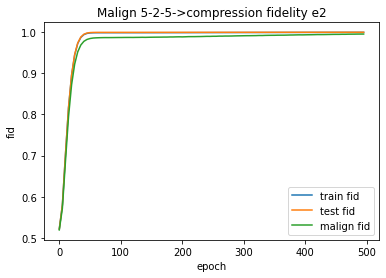

In [42]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist),label="train fid")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist_test),label="test fid")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(benign_fid),label="malign fid")

plt.legend()
plt.title("Malign 5-2-5->compression fidelity e2",)
plt.xlabel("epoch")
plt.ylabel("fid")

print("fidelity:",fid_hist[-1])

loss: 1.0004360368170442


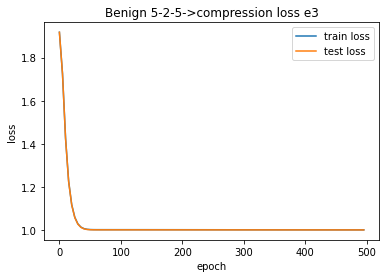

In [43]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist),label="train loss")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist_test),label="test loss")


plt.legend()
plt.title("Benign 5-2-5->compression loss e3",)
plt.xlabel("epoch")
plt.ylabel("loss")

print("loss:",loss_hist[-1])

In [35]:
name = "Cancer_encoder_e3"

Circuit_prop={   "shots":shots, "nr_trash":nr_trash, "nr_latent":nr_latent ,"nr_ent":nr_ent  }
Training_param = { "num_samples" : num_samples,
                    "batch_size" :batch_size,
                    "epochs" :epochs,
                    "learning_rate" : learning_rate ,
                    "beta1" : beta1,
                    "beta2 ":beta2,
                     "optimizer":"Adam"}

performance={"loss_hist":loss_hist, "fid_hist":fid_hist,
             "loss_hist_test":loss_hist_test, "fid_hist_test":fid_hist_test,
             "encoder_params":encoder_params}

experiment_data={"Circuit_prop":Circuit_prop,
                "Training_param":Training_param,
                "performance:":performance,
                "Name":name}

# open file for writing
f = open(name+".txt","w")
f.write( str(experiment_data) )

17269

## Benign performance 

In [36]:
np_benign = benign.to_numpy()
benign_data = [ torch.tensor([np_benign[i]]) for i in range(len(benign.to_numpy()))]

loss = cost(encoder_params, benign_data )
fidel = fidelity(encoder_params, benign_data )

print("Benign results:")
print("fidelity=",fidel)
print("loss=",loss)


C:\Users\tomut\anaconda3\envs\qhack2022\lib\site-packages\pennylane\math\multi_dispatch.py:63: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow and PyTorch over autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Benign results:
fidelity= 0.9955140521155781
loss= 1.0046502703716154


## Classifyer

In [37]:
beningn_flist=[]
for b in benign_data:
    f=fidelity(encoder_params, [b])
    beningn_flist.append(f.item())
    
print(min(beningn_flist))
print(max(beningn_flist))

0.9152852062126089
0.999965227245372


In [38]:
malign_flist=[]
for b in training_data:
    f=fidelity(encoder_params, [b])
    malign_flist.append(f.item())
    
print(min(malign_flist))
print(max(malign_flist))

0.9786799991846103
0.9999652058525136


In [39]:
beningn_flist

[0.9999645009908686,
 0.9999644943853203,
 0.9999113746132575,
 0.9999645013860532,
 0.9983948399665424,
 0.9691135718875602,
 0.9983948896380644,
 0.9999645017819297,
 0.9999644944268599,
 0.9999644943962618,
 0.999964501950278,
 0.9786798144701438,
 0.9950178526150149,
 0.9999645014624391,
 0.9999645615005441,
 0.9993873673325423,
 0.9999645014273292,
 0.9999112535151917,
 0.9983948946548673,
 0.9999112455926567,
 0.9999645014626234,
 0.9999645021375547,
 0.9999113744753247,
 0.9999113756984458,
 0.9969362634992995,
 0.9865406611488338,
 0.9999645011805071,
 0.9999645778204722,
 0.999964500996498,
 0.999965227245372,
 0.9999645015733959,
 0.9950179615262073,
 0.9786797861916691,
 0.9969371005488258,
 0.9993873936537778,
 0.9983948887352263,
 0.9999645013125572,
 0.9828271802118832,
 0.9999645015350811,
 0.9999644943133872,
 0.9993873968252558,
 0.9999113881525281,
 0.9999113744254208,
 0.9983948946714368,
 0.9993873936255265,
 0.9999113752692358,
 0.9999644936839955,
 0.9983948375852

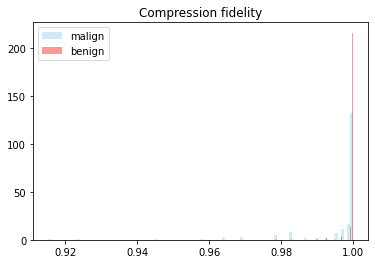

In [40]:
plt.hist(beningn_flist, bins = 100 ,label="malign", color = "skyblue",alpha=0.4)
plt.hist(malign_flist, bins =100 ,label="benign",color = "red",alpha=0.4)
plt.title("Compression fidelity",)
plt.legend()
plt.show()